In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [2]:
import McExperiment
from McExperiment import *
import importlib
importlib.reload(McExperiment)

<module 'McExperiment' from 'd:\\OneDriveLenovoD\\OneDrive\\A_Fall23\\FIN535\\HW2023\\FIN535-Final-23F\\Dec20\\FIN535-Final-23F\\McExperiment.py'>

In [3]:
data = pd.read_csv('data.csv')
data['month'] = data['month'].apply(lambda x: datetime.strptime(x, '%Y-%m')) #assume each date per month is the last day
data.set_index(['month'],inplace=True)

In [4]:
# read in optimal allocation from excel 
def read_condo_rst(n_strat=4):
    # return a table, row = objective, col = optimal allocation, and some critical stats
    ratios = []
    objs = []
    for i in range(n_strat): # for each objective, which corresponds to each sheet
        objs += [list(pd.read_excel('final sheet.xlsx', sheet_name=i).iloc[[11,13,15,17,19],8].values.astype('f'))]
        ratio = list(pd.read_excel('final sheet.xlsx', sheet_name=i).iloc[2,7:12].values.astype('f'))
        ratio[4] *= -1
        ratios += [ratio]
    opt_ratios = pd.DataFrame(ratios, index = ['max uti','max sharpe','max sortino','min mdd'], 
                  columns=['x1','x2','x3','x4','x5'])
    opt_objs = pd.DataFrame(objs, index = ['max uti','max sharpe','max sortino','min mdd'],\
                        columns = ['sharpe','mdd','uti','CE','sortino'])
    return pd.concat([opt_ratios, opt_objs],axis = 1)

n_strat=4
opt_excel_soln = read_condo_rst(n_strat)
opt_excel_soln

,x1,x2,x3,x4,x5,sharpe,mdd,uti,CE,sortino
max uti,0.181262,1.024393,0.750000,0.75,-0.205655,1.097224,0.250001,0.006363,12.076599,1.583711
max sharpe,0.490185,0.509815,0.342315,0.75,-0.000000,1.552223,0.250000,0.005783,12.069595,2.142872
max sortino,0.484227,0.515773,0.356543,0.75,-0.000000,1.551894,0.250000,0.005807,12.069884,2.143256
min mdd,0.463338,0.536662,0.280175,0.75,-0.000000,1.510296,0.196292,0.005592,12.067296,2.096605


In [5]:
# Read ratios from grid search 
with open('storage cache/df_results.pkl', 'rb') as file:
    grid_ratios = pickle.load(file)

#### Note:

excel results are quite different from the sim results because:
- sim is not a good method and has many cons
- max uti in sim result is max(cap after tax), excel is max mean(each log(1+simple return))
- sim result's sharpe and sortino did not minus risk-free in the numerator
- 

### Add bench and initilize + Run results

In [6]:
bench_ratio = pd.DataFrame(np.array([[0.6,0.4,0,0,0], [0.7,0.3,0,0,0], [0.5,0.5,0,0,0]]),\
    columns = ['x1','x2','x3','x4','x5'], index = ['bench6/4','bench7/3','bench5/5'])

ratios = pd.concat([bench_ratio,opt_excel_soln.iloc[np.r_[0,2:4],:5],\
    grid_ratios.iloc[np.r_[0,2:5],:]], axis = 0)

In [7]:
# Only keep the max sortino (drop max sharpe)
ratios.index

Index(['bench6/4', 'bench7/3', 'bench5/5', 'max uti', 'max sortino', 'min mdd',
       'uti', 'sortino', 'mdd', 'prob'],
      dtype='object')

In [8]:
condo_rst = dict()
condo_rst['ratios'] = ratios
condo_rst['Simu_table'] = [] # simulated results before taking the avg
condo_rst['Cap_table'] = [] # for the financial diamond construction
condo_rst['Summary_table'] = [] # after taking the avg of simulated results, then compute some critical stats


In [9]:
SAVE = 40000
CAP = 50000
g = 0.11
MC = 500
path_length = 120 # 10 year
tax_rate = 0.25


for i in tqdm(range(len(ratios))):
    ratio = (ratios.iloc[i,:]).to_list()
    # Get the analysis for end of 5Y/7Y/9Y  
    Simu_table, Simu_cap_table = Experiments(MC,path_length,data,CAP,SAVE,g,ratio,years=[60,84,120],tax=tax_rate)
    Summary_table, cap_table = GetSummary(Simu_table, Simu_cap_table, path_length)
    Summary_table = Summary_table.fillna(0)
    condo_rst['Simu_table'].append(Simu_table)
    condo_rst['Cap_table'].append(cap_table)
    condo_rst['Summary_table'].append(Summary_table)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


In [10]:
with open('storage cache/condo_rst.pkl', 'wb') as file:
    pickle.dump(condo_rst, file)

### Save the results: Plots and Tables

In [3]:
with open('storage cache/condo_rst.pkl', 'rb') as file:
        condo_rst = pickle.load(file)

In [11]:
# Get stat table:
ptf_name = ['bench6/4', 'bench7/3', 'bench5/5', 'max uti', 'max sortino', 'min mdd',\
    'mc max uti', 'mc max sortino', 'mc min dd','mc max prob']

df_full = pd.concat(condo_rst['Summary_table'])

In [13]:
df_5Y = df_full.loc[df_full.index == '5Y']
indexstr = [sub + ' 5Y' for sub in ptf_name] 
df_5Y.index = indexstr
df_5Y.to_csv('storage cache/stat_condo_5Y.csv')

In [14]:
df_7Y = df_full.loc[df_full.index == '7Y']
indexstr = [sub + ' 7Y' for sub in ptf_name] 
df_7Y.index = indexstr
df_7Y.to_csv('storage cache/stat_condo_7Y.csv')

In [15]:
df_10Y = df_full.loc[df_full.index == '10Y']
indexstr = [sub + ' 10Y' for sub in ptf_name] 
df_10Y.index = indexstr
df_10Y.to_csv('storage cache/stat_condo_10Y.csv')

In [16]:
df_cap = pd.concat(condo_rst['Cap_table'],axis = 1)
df_cap.columns = ptf_name

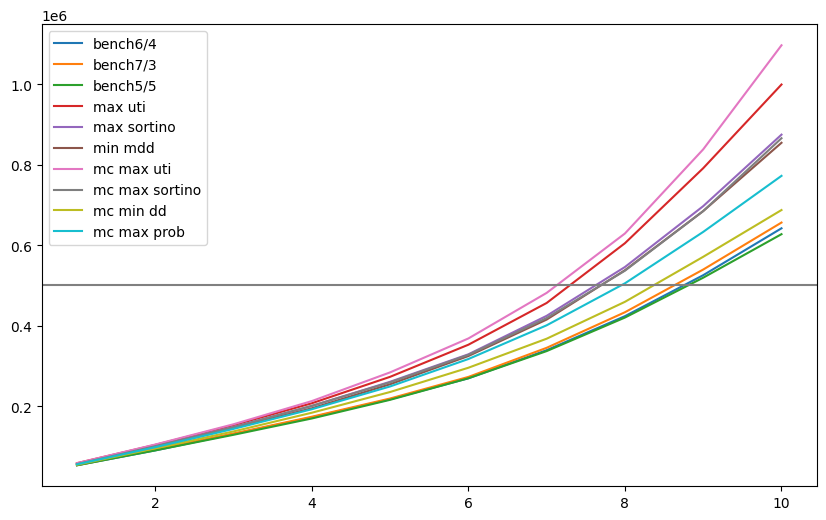

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(df_cap)
plt.axhline(y=500000, color='grey', linestyle='-')
plt.legend(ptf_name)
# plt.savefig('figures/condo_capitalplot_all.png',bbox_inches='tight')
plt.show()


In [37]:
df_5Y

,Expected Cap,Std Cap,Exp Cap < 500k,Prob >= 500k,Expected Annual_sharpe,Expected Annual_sortino,Expected MDD,ret VaR,ret CVaR,cap VaR,cap CVaR
bench6/4 5Y,219358.941579,48735.878902,219358.941579,0.0,1.152187,1.568353,0.174422,0.052542,-0.009234,-376866.326667,-377206.412035
bench7/3 5Y,216009.458376,46656.698248,216009.458376,0.0,0.995753,1.375427,0.232582,-0.034797,-0.105604,-376873.590389,-377693.034874
bench5/5 5Y,219366.743325,49130.051278,219366.743325,0.0,1.142624,1.509593,0.141305,0.121183,0.081306,-377315.569716,-377437.496748
max uti 5Y,281591.540497,67167.006228,281591.540497,0.0,1.158030,1.678318,0.186775,0.543495,0.541983,-354219.647251,-356494.296161
max sortino 5Y,261626.545288,64320.196410,261626.545288,0.0,1.660710,2.190347,0.132939,0.543457,0.522916,-366646.465827,-368852.958279
min mdd 5Y,257167.296337,68183.713581,257167.296337,0.0,1.605400,2.125509,0.124779,0.559278,0.491382,-374075.693370,-374075.693370
mc max uti 5Y,280140.685266,63222.275668,280140.685266,0.0,1.369650,1.866058,0.192723,0.515705,0.515705,-341021.977083,-345797.835522
mc max sortino 5Y,252811.143620,60522.211255,252811.143620,0.0,1.601418,2.112455,0.161769,0.429626,0.362838,-367496.646248,-367496.646248
mc min dd 5Y,228771.304958,56385.705703,228771.304958,0.0,1.079275,1.537098,0.120013,0.283421,0.283421,-375233.490017,-375233.490017
mc max prob 5Y,246629.803146,58792.356712,246629.803146,0.0,1.186723,1.670872,0.141156,0.459575,0.442936,-368056.401007,-370460.657887
